
原文地址如下
https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

- 原教程中代码里的注释保留英语的同时给出译文，而代码外的教程部分只保留译文。


# 通过例子学习PYTORCH
- 本教程通过独立的示例介绍了PyTorch的基本概念 。

- PyTorch的核心是提供两个主要功能：

n维张量，类似于numpy，但可以在GPU上运行
自动区分以构建和训练神经网络
我们将使用拟合问题 y=sin(x)y=sin⁡(x)以三阶多项式作为我们的运行示例。该网络将具有四个参数，并且将通过使网络输出与真实输出之间的欧几里德距离最小化来进行梯度下降训练，以适应随机数据。

# 第一部分 --  张量
## 热身：numpy
- 在介绍PyTorch之前，我们将首先使用numpy实现网络。

Numpy提供了一个n维数组对象，以及许多用于操纵这些数组的函数。Numpy是用于科学计算的通用框架；它对计算图，深度学习或梯度一无所知。但是，我们可以通过使用numpy操作手动实现通过网络的前向和后向传递，来轻松地使用numpy将三阶多项式拟合为正弦函数：

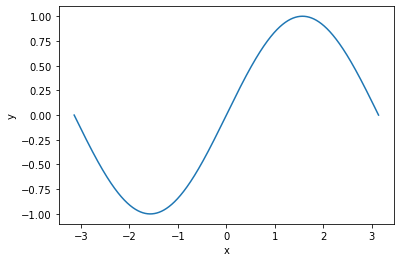

随机生成的参数----> -0.5356467754806087 0.1993793299756014 -0.6857513748898223 1.1697301363994252
99 583.5730837618062
199 393.6880007356551
299 266.71997059514814
399 181.7663425856291
499 124.885921837403
599 86.7749661114666
699 61.22113554386569
799 44.07389126437748
899 32.558522870670224
999 24.818905679142286
1099 19.612570691685885
1199 16.107245099794845
1299 13.745023575550828
1399 12.15163787696261
1499 11.07581482104901
1599 10.348719208888067
1699 9.856811684535437
1799 9.523671873984235
1899 9.297816798336873
1999 9.144531062541553
Result: y = -0.012763535706962538 + 0.8436279774377612 x + 0.0022019222956019473 x^2 + -0.09146519809171313 x^3


In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import math
# 这个plt是我额外加上去的 只是用作看一下图像
import matplotlib.pyplot as plt


# Create random input and output data
# 随机生成输入值 再用 sin函数生成对应输出  最后我们自己搞一个三阶多项式来拟合这个sin函数曲线
# lispace是在-pi到+pi之间生成2000个数作为输入
x = np.linspace(-math.pi, math.pi, 2000)
y = np.sin(x)

# 绘制出x,y构成的图像
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x,y)
plt.show()


# Randomly initialize weights
# 随机生成多项式的参数
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()
print("随机生成的参数---->",a,b,c,d)

# 定义学习率为1e-6
learning_rate = 1e-6

for t in range(2000):
    # 用随机生成参数的多项式来算出对于的预测值y
    # Forward pass: compute predicted y
    # y = a + b x + c x^2 + d x^3
    y_pred = a + b * x + c * x ** 2 + d * x ** 3

    # Compute and print loss
    # 计算损失函数 y预测值-y真实值的差求平方 
    # loss函数是MSE均方误差
    loss = np.square(y_pred - y).sum()
    if t % 100 == 99:
        print(t, loss)

    # 反向传播来调整参数abcd
    # Backprop to compute gradients of a, b, c, d with respect to loss
    # 这里是自己手动求导的过程 因为均方误差是(y_pred-y)的平方 求导后就是 2*(y_pred-y)
    grad_y_pred = 2.0 * (y_pred - y)  
    # 再用求得的梯度来计算每个参数的梯度 再来更新参数权值
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # Update weights
    # 通过学习率和各个的梯度来更新多项式的权值
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')

## PyTorch：张量
Numpy是一个很好的框架，但是它不能利用GPU来加速其数值计算。对于现代深度神经网络，GPU通常可以提供50倍或更高的加速比，因此不幸的是，仅凭numpy不足以实现现代深度学习。

在这里，我们介绍最基本的PyTorch概念：Tensor。PyTorch张量在概念上与numpy数组相同：张量是n维数组，而PyTorch提供了许多在这些张量上进行操作的功能。在幕后，张量可以跟踪计算图和渐变，但它们也可用作科学计算的通用工具。

与numpy不同，PyTorch张量可以利用GPU加速其数字计算。要在GPU上运行PyTorch Tensor，您只需要指定正确的设备即可。

- 在这里，我们使用PyTorch张量将三阶多项式拟合为正弦函数。像上面的numpy示例一样，我们需要手动实现通过网络的正向和反向传递：

In [2]:
# -*- coding: utf-8 -*-

import torch
import math


dtype = torch.float
device = torch.device("cpu")
# 设置设备为CPU 在CPU上运行 如果要在显卡上运行就改字符串为GPU
# device = torch.device("cuda:0") # Uncomment this to run on GPU

# Create random input and output data
# 随机生成输入值 再用 sin函数生成对应输出  最后我们自己搞一个三阶多项式来拟合这个sin函数曲线
# lispace是在-pi到+pi之间生成2000个数作为输入
x = torch.linspace(-math.pi, math.pi, 2000, device=device, dtype=dtype)
y = torch.sin(x)

# Randomly initialize weights
# 随机生成张量作为多项式的参数 同时设置设备为CPU 以及数据类型为浮点型
a = torch.randn((), device=device, dtype=dtype)
b = torch.randn((), device=device, dtype=dtype)
c = torch.randn((), device=device, dtype=dtype)
d = torch.randn((), device=device, dtype=dtype)

# 定义学习率
learning_rate = 1e-6

for t in range(2000):
    # 计算随机参数下的 预测值y
    # Forward pass: compute predicted y
    y_pred = a + b * x + c * x ** 2 + d * x ** 3


    # 定义损失函数 和上面numpy的例子一样，不过不能直接用numpy的方法 loss仍然是MSE
    # Compute and print loss
    loss = (y_pred - y).pow(2).sum().item()
    if t % 100 == 99:
        print(t, loss)


    # 反向传播来调整参数abcd
    # Backprop to compute gradients of a, b, c, d with respect to loss
    # 这里是自己手动求导的过程 因为均方误差是(y_pred-y)的平方 求导后就是 2*(y_pred-y)
    # 得到梯度值之后再对每一个参数求梯度 用作更新参数。
    grad_y_pred = 2.0 * (y_pred - y)
    grad_a = grad_y_pred.sum()
    grad_b = (grad_y_pred * x).sum()
    grad_c = (grad_y_pred * x ** 2).sum()
    grad_d = (grad_y_pred * x ** 3).sum()

    # 再用求得的梯度来计算每个参数的梯度 再来更新参数权值
    # Update weights using gradient descent
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d


print(f'Result: y = {a.item()} + {b.item()} x + {c.item()} x^2 + {d.item()} x^3')

99 2309.539794921875
199 1538.2750244140625
299 1025.906494140625
399 685.4260864257812
499 459.096923828125
599 308.59716796875
699 208.4849395751953
799 141.8652801513672
899 97.51563262939453
999 67.97854614257812
1099 48.29825973510742
1199 35.17927932739258
1299 26.429763793945312
1399 20.591285705566406
1499 16.6932430267334
1599 14.089241027832031
1699 12.348594665527344
1799 11.184389114379883
1899 10.405182838439941
1999 9.883291244506836
Result: y = 0.016559544950723648 + 0.8288812637329102 x + -0.0028567975386977196 x^2 + -0.08936759829521179 x^3
